In [221]:
import pandas as pd
import numpy as np
import math
from textblob import TextBlob

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

In [309]:
#https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt
d = pd.read_csv('amazon_reviews_us_Video_Games_v1_00.tsv', delimiter='\t', error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


In [551]:
data = d.copy()
data.dropna(subset=['review_body'], inplace=True)
data.drop(['marketplace', 'product_title', 'product_category', 'vine'], axis=1, inplace=True)

moreThan10Reviews = data['product_id'].value_counts() > 10
moreThan10Reviews = list(moreThan10Reviews.loc[moreThan10Reviews == True].index)

numbersOfReviewsByUser = data['customer_id'].value_counts()
data['reviews_by_user'] = data['customer_id'].map(numbersOfReviewsByUser)

averageRatingofProduct = data.groupby('product_id').mean()['star_rating']
data['average_rating'] = data['product_id'].map(averageRatingofProduct)


data = data.loc[data['total_votes'] > 4]
data = data.loc[data['product_id'].isin(moreThan10Reviews)]
data['helpful_ratio'] = data['helpful_votes'] / data['total_votes']

averageHelpfullnessofUser = data.groupby('customer_id').sum()['helpful_votes'] / data.groupby('customer_id').sum()['total_votes']
data['average_helpfullness'] = data['customer_id'].map(averageHelpfullnessofUser)

dummies = pd.get_dummies(data['verified_purchase'], prefix='verified')
data = pd.concat([data, dummies], axis=1).drop('verified_purchase', axis=1)

data['word_count'] = data['review_body'].apply(lambda x: len(x.split()))

data['rating_deviation'] = data['star_rating'] - data['average_rating']

scaler = MinMaxScaler(feature_range=(-1, 1))
rating_scaled = scaler.fit_transform(data['star_rating'].to_numpy().reshape(-1, 1))
data['rating_scaled'] = rating_scaled

avg_rating_scaled = scaler.fit_transform(data['average_rating'].to_numpy().reshape(-1, 1))
data['average_rating_scaled'] = avg_rating_scaled


data['rating_deviation_scaled'] = data['rating_scaled'] - data['average_rating_scaled']



data = data.sample(frac = 1)
data = data.head(100000)
data = data.reset_index(drop=True)


data

,customer_id,review_id,product_id,product_parent,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date,...,average_rating,helpful_ratio,average_helpfullness,verified_N,verified_Y,word_count,rating_deviation,rating_scaled,average_rating_scaled,rating_deviation_scaled
0,16093464,R1Z0M8RQ18DD2C,B000H229BE,730505829,4,14,14,Ex WOW Player,"After two years of playing WOW, I played the \...",2006-12-20,...,4.392857,1.000000,1.000000,1,0,282,-0.392857,0.5,0.696429,-0.196429
1,48490032,ROQ6JJ5CLM1LE,B0043QO6J8,333703784,5,1,8,A REALLY GREAT GAME !! you won't be disappointed,This game is the BEST EVER !!! I absolutely lo...,2011-04-11,...,3.190476,0.125000,0.125000,1,0,63,1.809524,1.0,0.095238,0.904762
2,29179934,R1N6PBM3IQNOJP,B003S55EWI,406860406,4,34,41,Excitement with a dash of disappointment.,Time Crisis: Razing Storm Review. Excitement w...,2010-10-19,...,4.115385,0.829268,0.916667,1,0,317,-0.115385,0.5,0.557692,-0.057692
3,12168493,R2LD5F73HJH0P3,B002N42SDS,905756976,5,5,6,"Finally, an excellent controller for guitarists","As a disclaimer, allow me to state that I am a...",2010-03-15,...,4.550000,0.833333,0.833333,0,1,1010,0.450000,1.0,0.775000,0.225000
4,22213683,R21RN5WV5B1NXH,B001TORSII,97286865,2,7,12,Simply Mediocre,Playing this game felt like playing a mediocre...,2010-08-15,...,4.635714,0.583333,0.583333,1,0,634,-2.635714,-0.5,0.817857,-1.317857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,17238801,RJFJZZZN2IBD,B002SU4QG4,789185320,1,17,23,Terrible Customer Support,I have never played a Bethesda Softworks game ...,2010-10-30,...,3.463668,0.739130,0.770270,1,0,304,-2.463668,-1.0,0.231834,-1.231834
99996,43534753,RZNTTFRMSGXCI,B002I0JZOC,635093167,5,7,10,Hands Down best Vita Deal!,"First of all, the Vita is a great piece of har...",2012-11-23,...,4.592998,0.700000,0.811321,0,1,758,0.407002,1.0,0.796499,0.203501
99997,21507824,R1XZNE4Q75PW5N,B000ZKA0J6,39181653,3,4,10,"Almost, but fell short.","I'll keep this short. The game itself is fun,...",2010-07-29,...,3.452681,0.400000,0.400000,1,0,134,-0.452681,0.0,0.226341,-0.226341
99998,36416729,RRT65LHUVUQ1O,B001IVPVVS,383053161,2,0,17,Garbage. Unless you like garbage.,The first scene looks like you are controlling...,2010-05-25,...,4.606061,0.000000,0.057971,0,1,44,-2.606061,-0.5,0.803030,-1.303030


In [552]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
wordnet_lemmatizer = WordNetLemmatizer()


sentences = list(data['review_body'])
#data['sentiment'] = data['review_body'].apply(sentiment)
sentiment = [None] * len(sentences)
exclamation = [None] * len(sentences)
caps = [None] * len(sentences)
index = 0
for i in sentences:
    
    lemmatized_list = []
    text_words = re.sub(r'\W+', ' ', i).split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    s = " ".join(lemmatized_list)
    sentiment[index] = TextBlob(s).sentiment
    index += 1
    if index % 1000 == 0:
        print(index)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000


In [553]:
polarity = pd.Series(sentiment)
polarity = polarity.apply(lambda x: x[0])
subjectivtydf = pd.Series(sentiment).apply(lambda x: x[1])
subjectivtydf

0        0.612714
1        0.490000
2        0.519501
3        0.545439
4        0.542435
           ...   
99995    0.459619
99996    0.546388
99997    0.449167
99998    0.390476
99999    0.550000
Length: 100000, dtype: float64

In [554]:
data['subjectivity'] = subjectivtydf
data['polarity'] = polarity - data['average_rating_scaled'] 

In [555]:
def helpfulChecker(ratio):
#     if ratio <= 0.33:
#         return -1
#     if ratio > 0.33 and ratio <= 0.66:
#         return 0
#     else:
#         return 1
    if ratio < 0.75:
        return 0
    return 1

data['helpful'] = data['helpful_ratio'].apply(helpfulChecker)

In [556]:
data

,customer_id,review_id,product_id,product_parent,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date,...,verified_N,verified_Y,word_count,rating_deviation,rating_scaled,average_rating_scaled,rating_deviation_scaled,subjectivity,polarity,helpful
0,16093464,R1Z0M8RQ18DD2C,B000H229BE,730505829,4,14,14,Ex WOW Player,"After two years of playing WOW, I played the \...",2006-12-20,...,1,0,282,-0.392857,0.5,0.696429,-0.196429,0.612714,-0.673190,1
1,48490032,ROQ6JJ5CLM1LE,B0043QO6J8,333703784,5,1,8,A REALLY GREAT GAME !! you won't be disappointed,This game is the BEST EVER !!! I absolutely lo...,2011-04-11,...,1,0,63,1.809524,1.0,0.095238,0.904762,0.490000,0.299762,0
2,29179934,R1N6PBM3IQNOJP,B003S55EWI,406860406,4,34,41,Excitement with a dash of disappointment.,Time Crisis: Razing Storm Review. Excitement w...,2010-10-19,...,1,0,317,-0.115385,0.5,0.557692,-0.057692,0.519501,-0.488489,1
3,12168493,R2LD5F73HJH0P3,B002N42SDS,905756976,5,5,6,"Finally, an excellent controller for guitarists","As a disclaimer, allow me to state that I am a...",2010-03-15,...,0,1,1010,0.450000,1.0,0.775000,0.225000,0.545439,-0.630089,1
4,22213683,R21RN5WV5B1NXH,B001TORSII,97286865,2,7,12,Simply Mediocre,Playing this game felt like playing a mediocre...,2010-08-15,...,1,0,634,-2.635714,-0.5,0.817857,-1.317857,0.542435,-0.847171,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,17238801,RJFJZZZN2IBD,B002SU4QG4,789185320,1,17,23,Terrible Customer Support,I have never played a Bethesda Softworks game ...,2010-10-30,...,1,0,304,-2.463668,-1.0,0.231834,-1.231834,0.459619,-0.225590,0
99996,43534753,RZNTTFRMSGXCI,B002I0JZOC,635093167,5,7,10,Hands Down best Vita Deal!,"First of all, the Vita is a great piece of har...",2012-11-23,...,0,1,758,0.407002,1.0,0.796499,0.203501,0.546388,-0.576562,0
99997,21507824,R1XZNE4Q75PW5N,B000ZKA0J6,39181653,3,4,10,"Almost, but fell short.","I'll keep this short. The game itself is fun,...",2010-07-29,...,1,0,134,-0.452681,0.0,0.226341,-0.226341,0.449167,-0.164977,0
99998,36416729,RRT65LHUVUQ1O,B001IVPVVS,383053161,2,0,17,Garbage. Unless you like garbage.,The first scene looks like you are controlling...,2010-05-25,...,0,1,44,-2.606061,-0.5,0.803030,-1.303030,0.390476,-0.881602,0


In [374]:
data['helpful'].value_counts()

0    61056
1    38944
Name: helpful, dtype: int64

In [375]:
data.columns

Index(['customer_id', 'review_id', 'product_id', 'product_parent',
       'star_rating', 'helpful_votes', 'total_votes', 'review_headline',
       'review_body', 'review_date', 'reviews_by_user', 'average_rating',
       'helpful_ratio', 'average_helpfullness', 'verified_N', 'verified_Y',
       'word_count', 'rating_deviation', 'rating_scaled',
       'average_rating_scaled', 'rating_deviation_scaled', 'polarity',
       'helpful'],
      dtype='object')

In [557]:
X = data.drop(['customer_id', 'review_id', 'product_id', 'product_parent',
       'star_rating', 'helpful_votes', 'total_votes', 'review_headline',
       'review_body', 'review_date', 
        'helpful_ratio',
        'average_helpfullness',
       'average_rating', 'rating_deviation', 'helpful'], axis=1)
y= data['helpful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [558]:
X

,reviews_by_user,verified_N,verified_Y,word_count,rating_scaled,average_rating_scaled,rating_deviation_scaled,subjectivity,polarity
0,1,1,0,282,0.5,0.696429,-0.196429,0.612714,-0.673190
1,1,1,0,63,1.0,0.095238,0.904762,0.490000,0.299762
2,2,1,0,317,0.5,0.557692,-0.057692,0.519501,-0.488489
3,2,0,1,1010,1.0,0.775000,0.225000,0.545439,-0.630089
4,1,1,0,634,-0.5,0.817857,-1.317857,0.542435,-0.847171
...,...,...,...,...,...,...,...,...,...
99995,9,1,0,304,-1.0,0.231834,-1.231834,0.459619,-0.225590
99996,7,0,1,758,1.0,0.796499,0.203501,0.546388,-0.576562
99997,1,1,0,134,0.0,0.226341,-0.226341,0.449167,-0.164977
99998,10,0,1,44,-0.5,0.803030,-1.303030,0.390476,-0.881602


In [416]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    1
99996    1
99997    1
99998    0
99999    1
Name: helpful, Length: 100000, dtype: int64

In [569]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_jobs = -1)).fit(X_train, y_train)
sel.get_support()


model = RandomForestClassifier(n_jobs = -1)
model.fit(sel.transform(X_train),y_train)
sel.get_support()

prediction = model.predict(sel.transform(X_test))

accuracy_score(prediction, y_test)

0.720925

In [577]:
sel.get_support()

array([False, False, False,  True, False,  True,  True,  True,  True])

In [575]:
X_train

,reviews_by_user,verified_N,verified_Y,word_count,rating_scaled,average_rating_scaled,rating_deviation_scaled,subjectivity,polarity
47622,2,1,0,34,-0.5,0.614068,-1.114068,0.416667,-0.939068
55696,2,1,0,183,-0.5,0.477551,-0.977551,0.517564,-0.483256
52647,1,1,0,384,-1.0,0.034390,-1.034390,0.471324,0.004881
43018,1,0,1,59,1.0,0.420787,0.579213,0.400000,-0.204120
53422,3,0,1,51,1.0,0.767553,0.232447,0.591623,-0.486424
...,...,...,...,...,...,...,...,...,...
50057,3,1,0,136,1.0,0.509554,0.490446,0.489474,-0.515694
98047,1,1,0,587,1.0,0.692308,0.307692,0.491362,-0.650644
5192,2,1,0,249,1.0,0.766667,0.233333,0.517640,-0.635007
77708,1,0,1,130,0.0,0.034390,-0.034390,0.513636,0.092883


In [572]:
selected_feat= X_train.columns[(sel.get_support())]
selected_feat

Index(['word_count', 'average_rating_scaled', 'rating_deviation_scaled',
       'subjectivity', 'polarity'],
      dtype='object')

In [568]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.66075

In [559]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1)

In [560]:
model.score(X_test, y_test)

0.72275

In [454]:
n_estimators = [10, 50, 100, 150]

# max_depth
max_depth = [20, 50, 100, 200, 300]

# min_samples_split
min_samples_split = [2, 3, 5, 10, 20]

# min_samples_leaf
min_samples_leaf = [1, 2, 3]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [10, 50, 100, 150], 'max_depth': [20, 50, 100, 200, 300], 'min_samples_split': [2, 3, 5, 10, 20], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [455]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=10, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 50, 100, 200, 300],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 5, 10, 20],
                                        'n_estimators': [10, 50, 100, 150]},
                   random_state=1, verbose=10)

In [456]:
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_depth': 300,
 'bootstrap': True}

In [ ]:
model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train,y_train)

In [458]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=300, min_samples_split=20, n_estimators=150,
                       n_jobs=-1)

In [465]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [462]:
mod = rf_random.best_estimator_.fit(X_train, y_train)
mod.score(X_test, y_test)

0.728125

In [467]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [280, 290, 300, 310],
    'min_samples_split': [19,20,21],
    'n_estimators': [140, 150, 160]
}
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 100)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Paralle

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [280, 290, 300, 310],
                         'min_samples_split': [19, 20, 21],
                         'n_estimators': [140, 150, 160]},
             verbose=100)

In [468]:
mod = grid_search.best_estimator_.fit(X_train, y_train)
mod.score(X_test, y_test)

0.72855

In [469]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 300,
 'min_samples_split': 21,
 'n_estimators': 160}

In [470]:
d

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780263,US,52758880,RPC430LWZJ60T,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,5,1,1,N,N,&quot;Riven&quot; generally lives up to its bi...,I don't think it is necessary for me to wax po...,1997-11-09
1780264,US,52477491,R347MZT5FH6HRJ,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,5,2,2,N,N,An Immersive Experience - A Work of Art,If I could rate higher than a ten I would. Thi...,1997-11-09
1780265,US,53023047,RJ5BETZP0VIUS,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,1,0,2,N,N,Riven - or Driven by Microsoft?,Fewer than 1 in 3 modern Windows computers are...,1997-11-08
1780266,US,53088309,R85QTDO2KZMGO,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,1,1,3,N,N,Disappointment !!!,Unfortunately Riven is available only to those...,1997-11-06


<AxesSubplot:title={'center':'Rating Distribution'}, xlabel='Rating', ylabel='Count'>

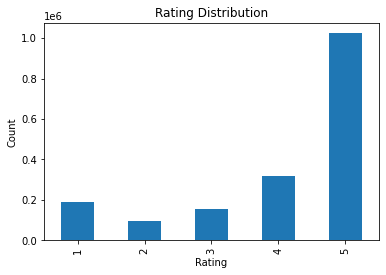

In [482]:
d['star_rating'].value_counts().loc[[1, 2, 3, 4, 5]].plot(xlabel = 'Rating', ylabel ='Count',title = 'Rating Distribution', kind = 'bar')

In [484]:
d['vine'].value_counts()

N    1775984
Y       4284
Name: vine, dtype: int64

In [490]:
1164785 / (4284+1775984) * 100


65.42750866723436

In [486]:
d['verified_purchase'].value_counts()

Y    1164785
N     615483
Name: verified_purchase, dtype: int64

In [491]:
data = d.copy()
data.dropna(subset=['review_body'], inplace=True)
data.drop(['marketplace', 'product_title', 'product_category', 'vine'], axis=1, inplace=True)

moreThan10Reviews = data['product_id'].value_counts() > 10
moreThan10Reviews = list(moreThan10Reviews.loc[moreThan10Reviews == True].index)

numbersOfReviewsByUser = data['customer_id'].value_counts()
data['reviews_by_user'] = data['customer_id'].map(numbersOfReviewsByUser)

averageRatingofProduct = data.groupby('product_id').mean()['star_rating']
data['average_rating'] = data['product_id'].map(averageRatingofProduct)


data = data.loc[data['total_votes'] > 4]
data = data.loc[data['product_id'].isin(moreThan10Reviews)]
data['helpful_ratio'] = data['helpful_votes'] / data['total_votes']

In [492]:
data

,customer_id,review_id,product_id,product_parent,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date,reviews_by_user,average_rating,helpful_ratio
26,25401563,R1FJWU0IJ4KUT4,B001BNFQKO,108570469,1,5,5,Y,DRM FAIL,Normally I wouldn't bother rating anythng 1 st...,2015-08-31,3,2.331461,1.000000
74,1085641,R2CI0Y288CC7E2,B00RHI62GY,626589765,1,21,35,Y,i request change article,"Yesterday i received my package, however, the ...",2015-08-31,11,4.333333,0.600000
209,34170274,R127WEQY2FM1T3,B00W435BU0,487294121,1,147,175,Y,Hot Mess. Don't Buy.,This is an absolute hot mess. EA has become i...,2015-08-31,1,3.283582,0.840000
259,10937940,RRTLCF5WCT7OG,B00MV7KVP4,92208606,3,3,7,N,The Game is Actually Playing You,A great game that could lay the benchmark for ...,2015-08-31,15,4.514085,0.428571
289,35781932,R3EZ0EPYLDA34S,B00PV515DU,986164434,1,14,31,Y,The reason that I am giving it such a poor rev...,I ordered this item for an overseas trip. The ...,2015-08-31,1,4.424000,0.451613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780228,52970427,RZZD9Z65IWOBS,B00000I1BB,997616104,4,4,5,N,Multi-player version is &quot;sweeeet!&quot;,The single-player version of this game gets mo...,1999-07-14,1,3.735849,0.800000
1780232,51311840,R1V4WP2GV41DYB,B00000DMAU,193059036,5,12,13,N,The most addictive and realistic racing simula...,With a mountain of racing games available for ...,1999-07-14,2,4.698795,0.923077
1780240,51644062,R2S47DOX47M9YA,B00000I1C3,300061473,4,5,8,N,YOU HAVE TO GET THIS GAME!!!!!!!!!,this game is great! you get to pick through a ...,1999-07-13,1,3.769231,0.625000
1780244,52091349,R160KLMRLU5S5U,B00000JL6V,334018759,1,0,5,N,"Pretty to look at, but boring",Can't imagine what all the hoo-ha was about. T...,1998-12-18,1,4.201149,0.000000


<AxesSubplot:ylabel='Frequency'>

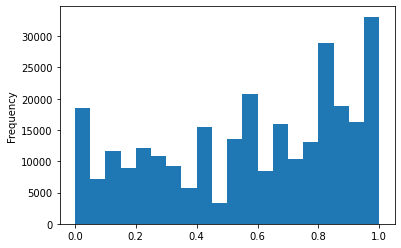

In [500]:
data['helpful_ratio'].plot.hist(bins=20)

<AxesSubplot:title={'center':'Helpful Ratio Frequency'}, ylabel='Frequency'>

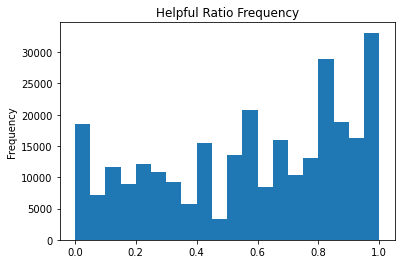

In [504]:
data['helpful_ratio'].plot.hist(bins=20,xlabel = 'Helpful Ratio', ylabel ='Frequency',title = 'Helpful Ratio Frequency')

In [511]:
data.groupby('star_rating').mean()['helpful_ratio']

star_rating
1    0.455964
2    0.504415
3    0.557868
4    0.676393
5    0.652893
Name: helpful_ratio, dtype: float64

<AxesSubplot:title={'center':'Average Helpful Ratio by Star Rating'}, xlabel='Star Rating', ylabel='Average Helpful Ratio'>

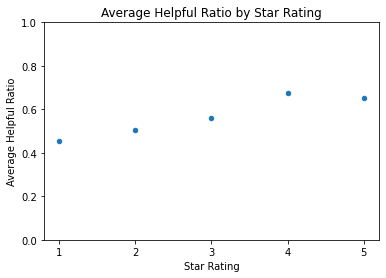

In [525]:
char= [[1, 0.455964], [2, 0.504415], [3, 0.557868], [4, 0.676393], [5, 0.652893 ]]

pd.DataFrame(char).rename(columns={0: 'Star Rating', 1: 'Average Helpful Ratio'}).plot(xlabel='Star Rating', ylabel = 'Average Helpful Ratio', x=0, y=1 ,title = 'Average Helpful Ratio by Star Rating', ylim=[0,1],kind='scatter', xticks=[1,2,3,4,5])

In [530]:
data['helpful'].value_counts()

0    172317
1    110216
Name: helpful, dtype: int64

In [533]:
172317 / (110216+172317)

0.6099004364091982

In [534]:
data

,customer_id,review_id,product_id,product_parent,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date,...,helpful_ratio,average_helpfullness,verified_N,verified_Y,word_count,rating_deviation,rating_scaled,average_rating_scaled,rating_deviation_scaled,helpful
0,25401563,R1FJWU0IJ4KUT4,B001BNFQKO,108570469,1,5,5,DRM FAIL,Normally I wouldn't bother rating anythng 1 st...,2015-08-31,...,1.000000,0.928571,0,1,221,-1.331461,-1.0,-0.334270,-0.665730,1
1,1085641,R2CI0Y288CC7E2,B00RHI62GY,626589765,1,21,35,i request change article,"Yesterday i received my package, however, the ...",2015-08-31,...,0.600000,0.381818,0,1,27,-3.333333,-1.0,0.666667,-1.666667,0
2,34170274,R127WEQY2FM1T3,B00W435BU0,487294121,1,147,175,Hot Mess. Don't Buy.,This is an absolute hot mess. EA has become i...,2015-08-31,...,0.840000,0.840000,0,1,372,-2.283582,-1.0,0.141791,-1.141791,1
3,10937940,RRTLCF5WCT7OG,B00MV7KVP4,92208606,3,3,7,The Game is Actually Playing You,A great game that could lay the benchmark for ...,2015-08-31,...,0.428571,0.740741,1,0,506,-1.514085,0.0,0.757042,-0.757042,0
4,35781932,R3EZ0EPYLDA34S,B00PV515DU,986164434,1,14,31,The reason that I am giving it such a poor rev...,I ordered this item for an overseas trip. The ...,2015-08-31,...,0.451613,0.451613,0,1,82,-3.424000,-1.0,0.712000,-1.712000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282528,52970427,RZZD9Z65IWOBS,B00000I1BB,997616104,4,4,5,Multi-player version is &quot;sweeeet!&quot;,The single-player version of this game gets mo...,1999-07-14,...,0.800000,0.800000,1,0,130,0.264151,0.5,0.367925,0.132075,1
282529,51311840,R1V4WP2GV41DYB,B00000DMAU,193059036,5,12,13,The most addictive and realistic racing simula...,With a mountain of racing games available for ...,1999-07-14,...,0.923077,0.923077,1,0,157,0.301205,1.0,0.849398,0.150602,1
282530,51644062,R2S47DOX47M9YA,B00000I1C3,300061473,4,5,8,YOU HAVE TO GET THIS GAME!!!!!!!!!,this game is great! you get to pick through a ...,1999-07-13,...,0.625000,0.625000,1,0,144,0.230769,0.5,0.384615,0.115385,0
282531,52091349,R160KLMRLU5S5U,B00000JL6V,334018759,1,0,5,"Pretty to look at, but boring",Can't imagine what all the hoo-ha was about. T...,1998-12-18,...,0.000000,0.000000,1,0,28,-3.201149,-1.0,0.600575,-1.600575,0


In [536]:
baseline1pred = []
for index, row in data.iterrows():
    if row['star_rating'] > (row['average_rating'] - 1) and row['star_rating'] < (row['average_rating'] +1):
        baseline1pred.append(1)
    else:
        baseline1pred.append(0)
baseline1pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,


In [537]:
accuracy_score(baseline1pred, data['helpful'])

0.6684741251464431

In [549]:
 data['customer_id'].value_counts().mean()

1.3848163433355227

In [550]:
baseline2pred = []
for index, row in data.iterrows():
    if row['reviews_by_user'] == 1:
        baseline2pred.append(0)
    else:
        baseline2pred.append(1)
baseline2pred
accuracy_score(baseline2pred, data['helpful'])

0.5174793740908141

In [581]:
data['review_body'].sort_values()[90103]

'!!!!!!!!!!!!!!!!!!!THIS CONTROLLER IS NOT WORTH A DIME. SELLERS WONT CONTACT YOU BACK AND CONTROLLER STOPS WORKING. NOT WORTH BUYING.!!!!!!!!!!!!!!!!<br />Great controller. It very fun to use but the rapid fire turns off once in a while. I will give it one more week of testing and ill fully rate it in my option but for now 3 stars.<br /><br />Update. It stops working while in mid game. I sent the seller and email like 2 weeks ago and never replied. Not worth buying'

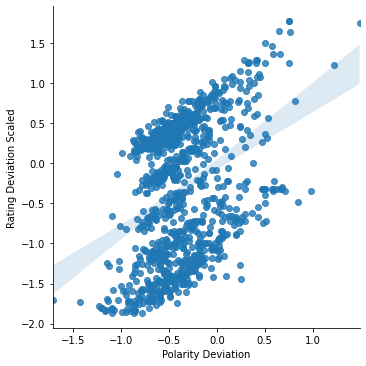

In [616]:
import matplotlib.pyplot as plt
g = sns.lmplot(x='polarity',y='rating_deviation_scaled', fit_reg=True, data=data.head(1000)) 
g.set(xlabel='Polarity Deviation', ylabel='Rating Deviation Scaled')

In [584]:
import seaborn as sns


NameError: name 'df' is not defined

In [617]:
from sklearn.metrics import f1_score

In [620]:
f1_score(prediction, y_test)

0.628061173491487